# 0 - Importações


In [1]:
#importações necessárias
import pandas as pd
import numpy as np
import statistics
import pickle
from scipy import stats as ss
from datetime import datetime, timedelta
from tabulate import tabulate
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

#importações para vizualisar dados
import seaborn as sns
from matplotlib import pyplot as plt

#importações dos algoritmos utilizados
import xgboost as xgb
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso

from IPython.display import Image
from IPython.core.display import HTML


import warnings
warnings.filterwarnings('ignore')

## 0.1 - Funções de apoio

In [2]:
def cramer_v(x,y):
    cm= pd.crosstab(x,y).values
    chi2= ss.chi2_contingency(cm)[0]
    n= cm.sum()
    r,k= cm.shape
    
    chi2corr= max(0,chi2-(k-1)*(r-1)/(n-1))
    kcorr= k - (k-1)**2/(n-1)
    rcorr= r - (r-1)**2/(n-1)
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))


#função de erro
def ml_error(model_name, y, yhat):
    mae= mean_absolute_error(y_true= y, y_pred= yhat)
    mape= mean_absolute_percentage_error(y_true= y, y_pred= yhat)
    rmse= np.sqrt(mean_squared_error(y_true= y, y_pred= yhat))
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE':rmse}, index= [0])


#Função Cross Validation - Time Series
def cross_validation(x_training, model_name, model, kfold, verbose= False):
    mae_list= []
    mape_list= []
    rmse_list= []
    
    for k in reversed( range(1, kfold+1) ):
        if verbose:
            print(f'\nKfold Number: {k}')
        #data de inicio e fim dos dados de validação
        validation_start = x_training['date'].max()- timedelta(days= k*6*7)
        validation_end = x_training['date'].max() - timedelta(days= (k-1)*6*7)

        #filtrando dataset por datas
        train = x_training[x_training['date']< validation_start]
        validation = x_training[(x_training['date']>= validation_start) & (x_training['date']<= validation_end)]

        #dados de treino e validação 
        #treino
        xtraining= train.drop(['date', 'item_cnt_day'], axis = 1)
        ytraining= train['item_cnt_day']

        #validação
        xvalidation= validation.drop(['date', 'item_cnt_day'], axis= 1)
        yvalidation= validation['item_cnt_day']

        #modelo
        m= model.fit(xtraining, ytraining)

        #previsão
        yhat= m.predict(xvalidation)

        #performance
        ml_result= ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        #média das performances por iterações (kfolds)
        mae_list.append(ml_result['MAE'])
        mape_list.append(ml_result['MAPE'])
        rmse_list.append(ml_result['RMSE'])
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list),2).astype(str)+ '+/-' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list),2).astype(str)+ '+/-' +np.round(np.std(mape_list),2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str)+ '+/-' +np.round(np.std(rmse_list),2).astype(str)}, index=[0])

## 0.2 - Carregamento dos dados

In [3]:
#carregando os dados 
data= pd.read_csv('predict_sales_store/sales_train.csv')
categories= pd.read_csv('predict_sales_store/item_categories_pt.csv')
itens= pd.read_csv('predict_sales_store/items.csv')
shops= pd.read_csv('predict_sales_store/shop_eng.csv')

#unindo os dados
df_raw= pd.merge(data, shops, how= 'left', on= 'shop_id')
df_raw= pd.merge(df_raw, itens, how= 'left', on= 'item_id')
df_raw= pd.merge(df_raw, categories, how= 'left', on= 'item_category_id')

In [4]:
df_raw.head(5)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,shop_city,shop_type,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.00,1.0,"Yaroslavl shopping center center ""Altair""",Yaroslavl,shopping center,ЯВЛЕНИЕ 2012 (BD),37,Filme-Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,"Moscow shopping center center ""Atrium""",Moscow,shopping center,DEEP PURPLE The House Of Blue Light LP,58,Música - Vinil
2,05.01.2013,0,25,2552,899.00,-1.0,"Moscow shopping center center ""Atrium""",Moscow,shopping center,DEEP PURPLE The House Of Blue Light LP,58,Música - Vinil
3,06.01.2013,0,25,2554,1709.05,1.0,"Moscow shopping center center ""Atrium""",Moscow,shopping center,DEEP PURPLE Who Do You Think We Are LP,58,Música - Vinil
4,15.01.2013,0,25,2555,1099.00,1.0,"Moscow shopping center center ""Atrium""",Moscow,shopping center,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Música - CD de marca


# 1 - Descrição dos dados

In [5]:
df1= df_raw.copy()

## 1.1 - Dimensão dos dados

In [6]:
print(f'Número de linhas: {df1.shape[0]}')
print(f'Número de colunas: {df1.shape[1]}')

Número de linhas: 2935849
Número de colunas: 12


## 1.2 - Tipo de dados

In [7]:
df1.dtypes

date                   object
date_block_num          int64
shop_id                 int64
item_id                 int64
item_price            float64
item_cnt_day          float64
shop_name              object
shop_city              object
shop_type              object
item_name              object
item_category_id        int64
item_category_name     object
dtype: object

In [8]:
df1['date']= pd.to_datetime(df1['date'])
df1['date'] 

0         2013-02-01
1         2013-03-01
2         2013-05-01
3         2013-06-01
4         2013-01-15
             ...    
2935844   2015-10-10
2935845   2015-09-10
2935846   2015-10-14
2935847   2015-10-22
2935848   2015-03-10
Name: date, Length: 2935849, dtype: datetime64[ns]

## 1.3 - Check  de valores faltantes

In [9]:
df1.isna().sum()#não temos valores faltantes então não vamos precisar fazer o tratamento 

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
shop_name             0
shop_city             0
shop_type             0
item_name             0
item_category_id      0
item_category_name    0
dtype: int64

## 1.4 - Estatística Descritiva

In [10]:
var_num = df1.select_dtypes(include=['int64','float64'])
var_cat = df1.select_dtypes(include= ['object'])

In [11]:
#medidas de tendência central(média, mediana, moda)
ct1 = pd.DataFrame(var_num.apply(np.mean)).T
ct2 = pd.DataFrame(var_num.apply(np.median)).T
ct3 = pd.DataFrame(var_num.apply(statistics.mode)).T

#medidas de disperçao, max, min,range, desvio padrão, skew, kurtoses
d1= pd.DataFrame(var_num.apply(min)).T
d2= pd.DataFrame(var_num.apply(max)).T
d3= pd.DataFrame(var_num.apply(lambda x: x.max()- x.min())).T
d4= pd.DataFrame(var_num.apply(np.std)).T
d5= pd.DataFrame(var_num.apply(lambda x: x.skew())).T
d6= pd.DataFrame(var_num.apply(lambda x: x.kurtosis())).T

#concatenando
e_descr= pd.concat([d1,d2,d3,ct1,ct2,ct3,d4,d5,d6]).T.reset_index()
e_descr.columns= (['attributes','min', 'max','range','mean','median','moda', 'std', 'skew', 'kurtosis'])

e_descr

,attributes,min,max,range,mean,median,moda,std,skew,kurtosis
0,date_block_num,0.0,33.0,33.0,14.569911,14.0,11.0,9.422986,0.203858,-1.082869
1,shop_id,0.0,59.0,59.0,33.001728,31.0,31.0,16.226970,-0.072361,-1.025358
2,item_id,0.0,22169.0,22169.0,10197.227057,9343.0,20949.0,6324.296277,0.257174,-1.225210
3,item_price,-1.0,307980.0,307981.0,890.853233,399.0,299.0,1729.799336,10.750423,445.532826
4,item_cnt_day,-22.0,2169.0,2191.0,1.242641,1.0,1.0,2.618834,272.833162,177478.098774
5,item_category_id,0.0,83.0,83.0,40.001383,40.0,40.0,17.100756,0.318283,-0.525158


In [12]:
#Valore negativo- item_price
df1.loc[(df1['item_id']==2973)&(df1['shop_name']=='Moscow shopping center center "Silver House"'), ['item_price','item_id','item_cnt_day', 'shop_name', 'date']]

,item_price,item_id,item_cnt_day,shop_name,date
67427,2499.0,2973,1.0,"Moscow shopping center center ""Silver House""",2013-01-29
67428,2499.0,2973,1.0,"Moscow shopping center center ""Silver House""",2013-01-25
67429,2499.0,2973,1.0,"Moscow shopping center center ""Silver House""",2013-01-22
67430,2499.0,2973,1.0,"Moscow shopping center center ""Silver House""",2013-01-21
67431,2499.0,2973,1.0,"Moscow shopping center center ""Silver House""",2013-01-18
67432,2499.0,2973,1.0,"Moscow shopping center center ""Silver House""",2013-01-17
67433,2499.0,2973,3.0,"Moscow shopping center center ""Silver House""",2013-01-15
187844,2499.0,2973,1.0,"Moscow shopping center center ""Silver House""",2013-05-02
187845,2499.0,2973,1.0,"Moscow shopping center center ""Silver House""",2013-02-14
484682,1249.0,2973,1.0,"Moscow shopping center center ""Silver House""",2013-05-23


In [13]:
#valores negativo - item_cnt_day
df1.loc[df1['item_cnt_day']<0]


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,shop_city,shop_type,item_name,item_category_id,item_category_name
2,2013-05-01,0,25,2552,899.0,-1.0,"Moscow shopping center center ""Atrium""",Moscow,shopping center,DEEP PURPLE The House Of Blue Light LP,58,Música - Vinil
148,2013-01-23,0,25,2321,999.0,-1.0,"Moscow shopping center center ""Atrium""",Moscow,shopping center,Call of Duty: Black Ops II. Расширенное издани...,28,Jogos para PC - Edições extras
175,2013-07-01,0,25,2199,1449.0,-1.0,"Moscow shopping center center ""Atrium""",Moscow,shopping center,COLDPLAY Mylo Xyloto LP,58,Música - Vinil
807,2013-02-01,0,25,2330,599.0,-1.0,"Moscow shopping center center ""Atrium""",Moscow,shopping center,"Call of Duty: Black Ops [PC, Jewel, русская ве...",30,Jogos para PC - Edições Standard
1041,2013-01-13,0,25,5034,1989.0,-1.0,"Moscow shopping center center ""Atrium""",Moscow,shopping center,"NHL 13 [Xbox 360, русская документация]",23,Jogos-XBOX 360
...,...,...,...,...,...,...,...,...,...,...,...,...
2934243,2015-10-26,33,25,3917,449.0,-1.0,"Moscow shopping center center ""Atrium""",Moscow,shopping center,IRON MAIDEN The Book Of Souls 2CD,55,Música - CD produzido localmente
2934462,2015-10-18,33,25,4896,6398.0,-1.0,"Moscow shopping center center ""Atrium""",Moscow,shopping center,"Mortal Kombat X. Kollector's Edition [PS4, рус...",20,Jogos-PS4
2935263,2015-05-10,33,25,10039,249.0,-1.0,"Moscow shopping center center ""Atrium""",Moscow,shopping center,ВОССТАНИЕ ПЛАНЕТЫ ОБЕЗЬЯН (BD),37,Filme-Blu-Ray
2935643,2015-10-16,33,25,7893,2990.0,-1.0,"Moscow shopping center center ""Atrium""",Moscow,shopping center,X360: Геймпад беспроводной черный - Wireless C...,6,Acessórios - XBOX 360


In [14]:
b = df1.loc[df1['item_cnt_day']<0]
print(b['item_cnt_day'].unique())

[ -1.  -5.  -6.  -3.  -2.  -4. -22. -16.  -9.]


In [15]:
c= df1.loc[(df1['item_cnt_day']<=-22)|(df1['item_cnt_day']<=-4),['shop_name','item_price','item_cnt_day','item_id']]
display(c)

,shop_name,item_price,item_cnt_day,item_id
59155,E-shop online,2599.000000,-5.0,1590
59156,E-shop online,2599.000000,-6.0,1590
93576,"SPb shopping center center ""Sennaya""",1599.000000,-5.0,20384
222426,"Moscow shopping center center ""MEGA Teply Stan...",199.000000,-4.0,21323
940092,"St. Petersburg shopping center center ""Nevsky ...",2599.000000,-6.0,3732
1057907,E-shop online,15.000000,-22.0,8023
1058703,E-shop online,2599.000000,-4.0,3734
1835454,"Kazan shopping center center ""Parkhouse"" II",5.000000,-16.0,20949
2048519,E-shop online,1433.333333,-9.0,9242
2458733,"Adygea shopping center center ""Mega""",2899.000000,-5.0,16790


1. Como podemos observar temos um valor item_price no valor de -1 e alguns valores de item_cnt_day negativos tbm,no caso do valor do item_price vou colocar o valor que mais se repete do item na loja vendida no caso 2499.0.


2. Na situação do item_cnt_day podemos avaliar ser valores negativos de sáida/extorno/mercadorias devolvidas, ou então de digitação errada para esse primeiro ciclo de projeto vou considerar como se fossem mercadorias devolvidas como não sendo interessantes para meu dataset, como medida farei a filtagrem dessas linhas na egenharia de variáveis que correspondem a 0,37%, sendo maior parte deles de valores -1, a loja com valores maiores(-22...) é a online.

### 1.4.1 - Variáveis categóricas

In [16]:
var_cat.apply(lambda x: x.unique().shape[0])

shop_name                60
shop_city                30
shop_type                 3
item_name             21807
item_category_name       84
dtype: int64

# 2 - Engenharia de variáveis

In [17]:
df2= df1.copy()

## 2.1 - Mapa de Hipóteses

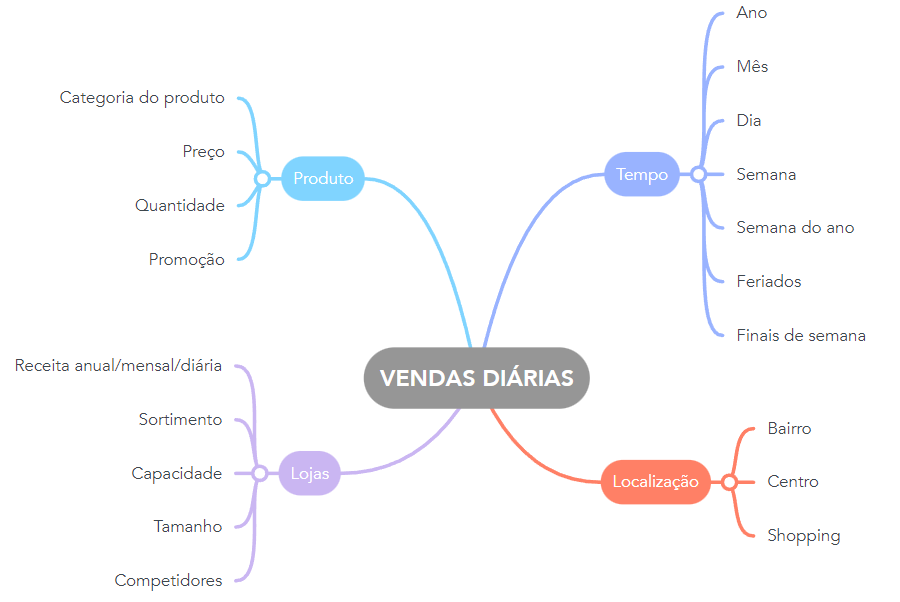

In [18]:
Image('MindMapHypot.png')

## 2.2 - Criação das Hipóteses

**Hipóteses - Loja**

**1.** Lojas com mais sortimento deveriam vender mais

**2.** Lojas com maior capacidade para estoque deveriam vender mais

**3.** Lojas com maior tamanho deveriam vender mais

**4.** Lojas com competidores mais próximos deveriam vender menos

**Hipóteses - Produto**

**5.** Lojas com produtos com preços menores deveriam vender mais

**6.** Lojas com promoção deveriam vender mais

**7.** Lojas com mais categorias de produtos deveriam vender mais

**Hipóteses - Localização**

**8.** Lojas no shopping deveriam vender mais

**9.** Lojas nos bairros deveriam vender menos

**10.** Lojas no centro deveriam vender mais

**Hipóteses - Tempo**

**11.** Lojas que abrem final de semana deveriam vender mais

**12.** Lojas no natal deveriam vender mais

**13.** Lojas nas férias escolares deveriam vender menos

**14.** Lojas no verão deveriam vender mais

**15.** Lojas até o dia 15 deveriam vender mais

**16.** Lojas ao longo dos anos deveriam vender mais

**17.** Lojas no primeiro semestre deveriam vender menos

**Lista das Hipóteses selecionadas**

**1.** Lojas com mais sortimento deveriam vender mais

**2.** Lojas com produtos com preços menores deveriam vender mais

**3.** Lojas com mais categorias de produtos deveriam vender mais

**4.** Lojas no shopping deveriam vender mais

**5.** Lojas no centro deveriam vender mais

**6.** Lojas que abrem final de semana deveriam vender mais

**7.** Lojas no natal deveriam vender mais

**8.** Lojas nas férias escolares deveriam vender menos

**9.** Lojas no verão deveriam vender mais

**10.** Lojas até o dia 15 deveriam vender mais

**11.** Lojas ao longo dos anos deveriam vender mais

**12.** Lojas no primeiro semestre deveriam vender menos



## 2.3 -  Engenharia das variáveis

In [19]:
#ano
df2['year']= df2['date'].dt.year
#mês
df2['month']= df2['date'].dt.month
#dia
df2['day']= df2['date'].dt.day
#dia da semana
df2['week_day']= df2['date'].dt.weekday
#semana do ano
df2['week_of_year']= df2['date'].dt.weekofyear
#ano da semana
df2['year_week']= df2['date'].dt.strftime('%Y-%W')

#extraindo categória geral do item
m= df2['item_category_name']
ms= list(map(lambda x: x.split('-')[0],m))
ms= list(map(lambda x: x.split( )[0], ms))
df2['category_general']= ms

#criando variável de feriados
df2['aux_date'] = df2['day'].astype(str)+'-'+df2['month'].astype(str)

df2['holidays']= df2['aux_date'].apply(lambda x: 'ano_n' if x== '1-1' else  
                                      'n_ortodoxo' if x=='7-1' else 
                                      'd_pátria' if x=='23-2' else
                                      'd_mulher' if x== '8-3' else 
                                      'primavera' if x =='1-5'else
                                      'd_vitória' if x =='9-5' else 
                                      'd_russia' if x== '12-6' else
                                      'd_povo' if x=='4-11' else 'nenhum')
df2.drop(columns=['aux_date'], inplace= True) #deletando coluna auxiliar

#criando variável com médias das temperaturas
df2['temperatures']= df2['month'].apply(lambda x: 'alta' if x in [5,6,7,8] else 
                                                  'média' if x in [4,9,10,11]  else
                                                  'baixa') 
#criando variável mês por ano

map_m= {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
        7:'Jul', 8:'Ago', 9:'Sep', 10:'Oct', 11:'Nov',12:'Dec'}
df2['month_']= df2['month'].map(map_m)
df2['month_year']= df2['month_']+'-'+df2['year'].astype(str)

#criando faixa de preço
df2['price_f'] = df2['item_price'].apply(lambda x: 50 if x <=50 else 
                                100 if (x >50) &  (x<=100) else
                                150 if (x >100) & (x<=150) else
                                200 if (x >150) & (x<=200) else
                                250 if (x >200) & (x<=250) else
                                300 if (x >250) & (x<=300) else
                                400 if (x >300) & (x<=400) else
                                500 if (x >400) & (x<=500) else
                                600 if (x >500) & (x<=600) else  
                                700 if (x >600) & (x<=700) else
                                800 if (x >700) & (x<=800) else
                                900 if (x >800) & (x<=900) else
                                1000 if (x >900) & (x<=1000) else
                                1500 if (x >1000) & (x<=1500) else
                                2000 if (x >1500) & (x<=2000) else
                                2500 if (x >2000) & (x<=2500) else
                                3000 if (x >2500) & (x<=3000) else
                                4000 if (x >3000) & (x<=4000) else
                                5000 if (x >4000) & (x<=5000) else
                                10000 if (x >5000) & (x<=10000) else  
                                20000 if (x >10000) & (x<=20000) else  
                                20000 if (x >10000) & (x<=20000) else 
                                30000 if (x >20000) & (x<=30000) else 40000)



# 3 - Filtragem das variáveis


In [20]:
df3= df2.copy()
#filtragem das linhas
df3['item_price']= df3['item_price'].replace([-1], 2499.0)

df3 = df3[df3['item_cnt_day']>0]


# 4 - Análise Exploratória de Dados

In [21]:
df4= df3.copy()

## 4.1 - Análise Univariada

### 4.1.1 Variável Resposta

<AxesSubplot:xlabel='item_cnt_day', ylabel='Density'>

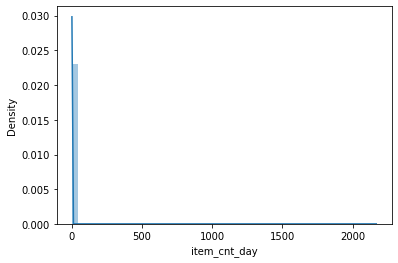

In [22]:
sns.distplot(df4['item_cnt_day'], kde= True)

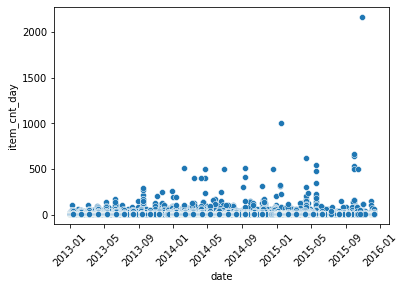

In [23]:
sns.scatterplot(x= 'date', y='item_cnt_day', data= df4);
plt.xticks(rotation= 45);

### 4.1.2 Variáveis numéricas

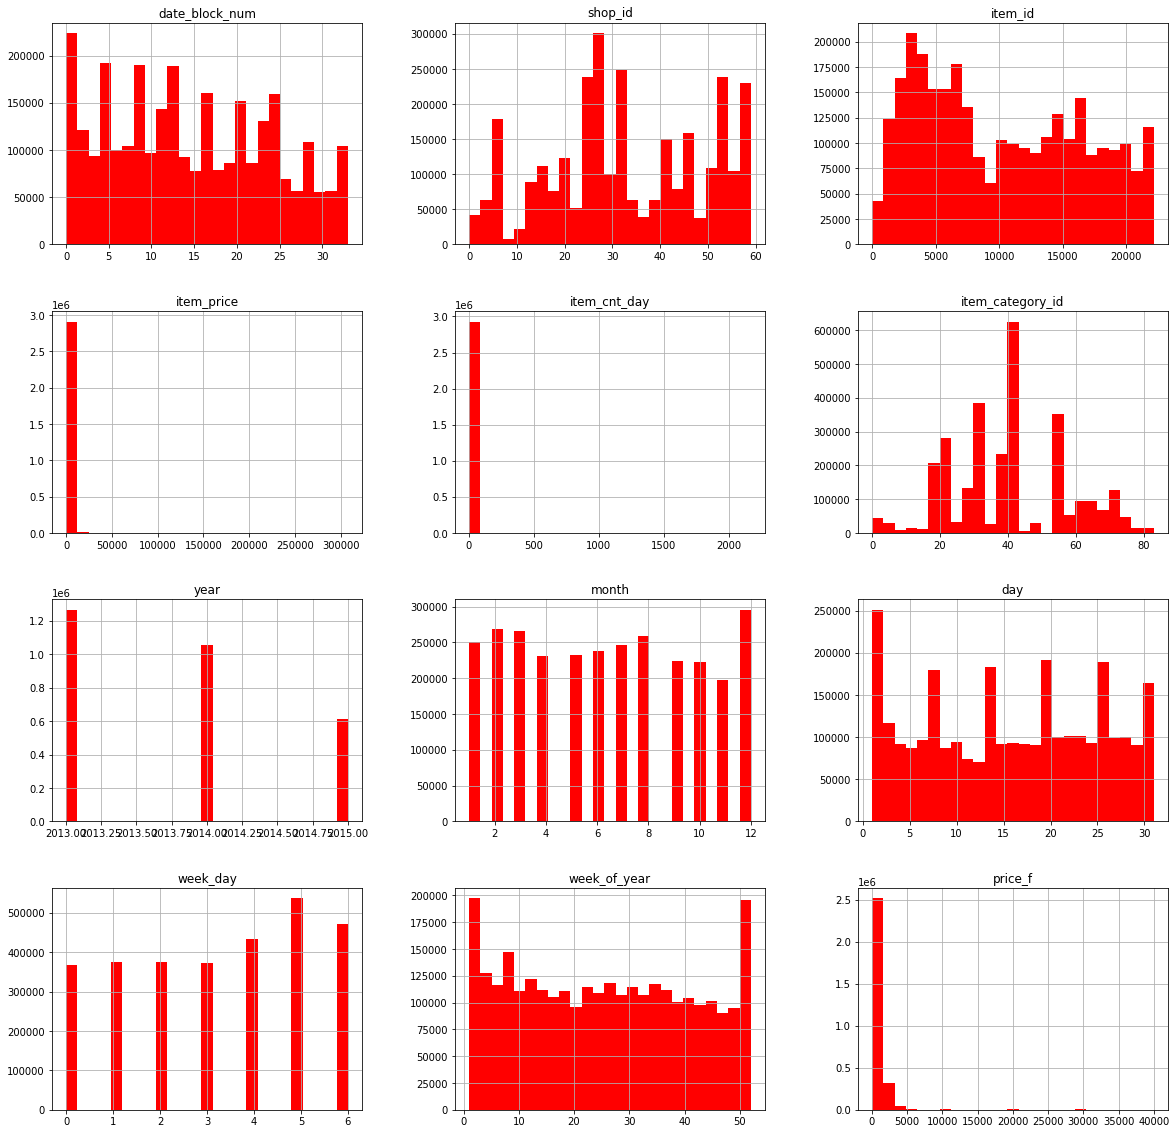

In [24]:
var_num = df4.select_dtypes(include= ['int64','float64'])
var_num.hist(bins= 25, figsize= (20,20), color= 'r');


### 4.1.3 Variável categóricas

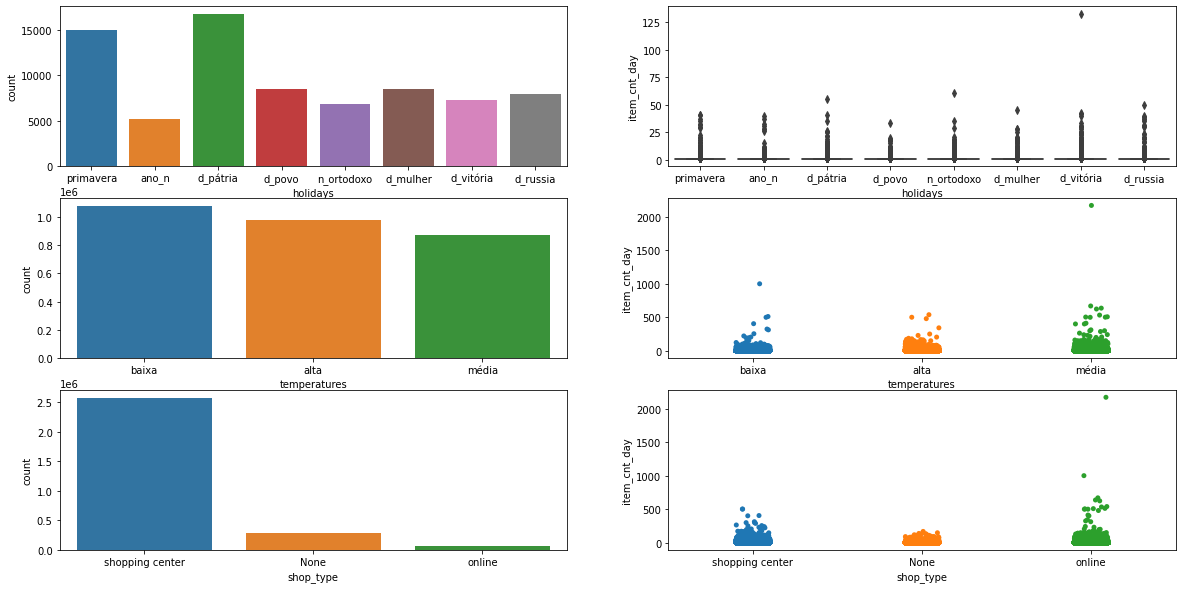

In [25]:
var_cat = df4.select_dtypes(include=['object'])
#holidays
plt.figure(figsize=[20,10])
plt.subplot(3,2,1)

h = df4[df4['holidays']!= 'nenhum']#filtro somente onde existe feriados
sns.countplot(h['holidays'])

plt.subplot(3,2,2)
sns.boxplot(x= 'holidays', y='item_cnt_day', data= h)

#temperatures
plt.subplot(3,2,3)
sns.countplot(df4['temperatures']);

plt.subplot(3,2,4)
sns.stripplot(x='temperatures', y='item_cnt_day', data=df4);

#shop_type
plt.subplot(3,2,5)
sns.countplot(df4['shop_type']);

plt.subplot(3,2,6)
sns.stripplot(x='shop_type', y='item_cnt_day', data=df4);


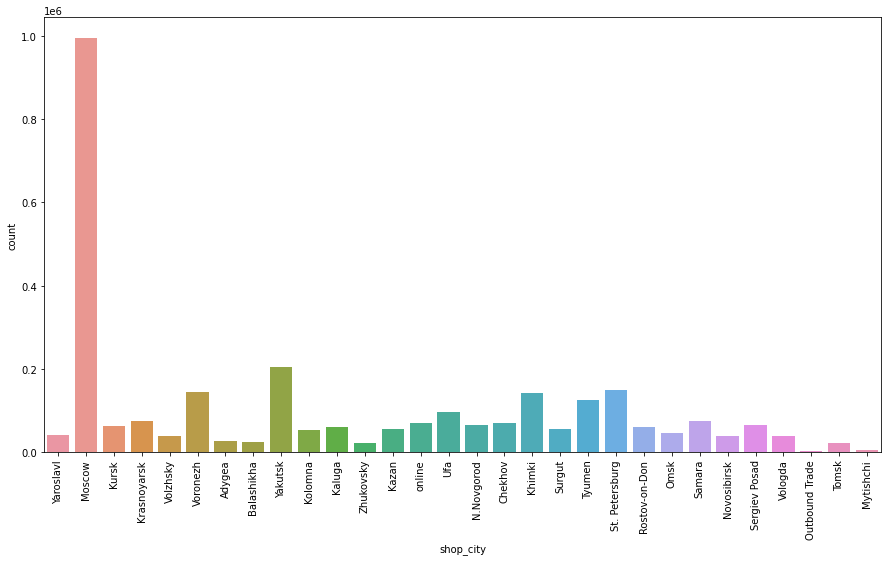

In [26]:
#shop_city
plt.figure(figsize=[15,8])
sns.countplot(df4['shop_city']);
plt.xticks(rotation= 90);

## 4.2 - Análise Bivariada

Lista das Hipóteses selecionadas
1. Lojas ao longo dos anos deveriam vender mais

2. Lojas no primeiro semestre deveriam vender menos 

3. Lojas até o dia 15 deveriam vender mais

3. Lojas no shopping deveriam vender mais 

4. Lojas nos meses de temperaturas quentes deveriam vender mais

5. Lojas no natal deveriam vender mais

6. Lojas que abrem final de semana deveriam vender mais 

7. Lojas no centro de Moscow deveriam vender mais 

8. Lojas no shopping center deveriam vender mais

9. Produtos com faixa de preço menores deveriam vender mais



### H1 -  Lojas ao longo dos anos deveriam vender mais
**FALSA** Lojas vendem menos ao longo dos anos

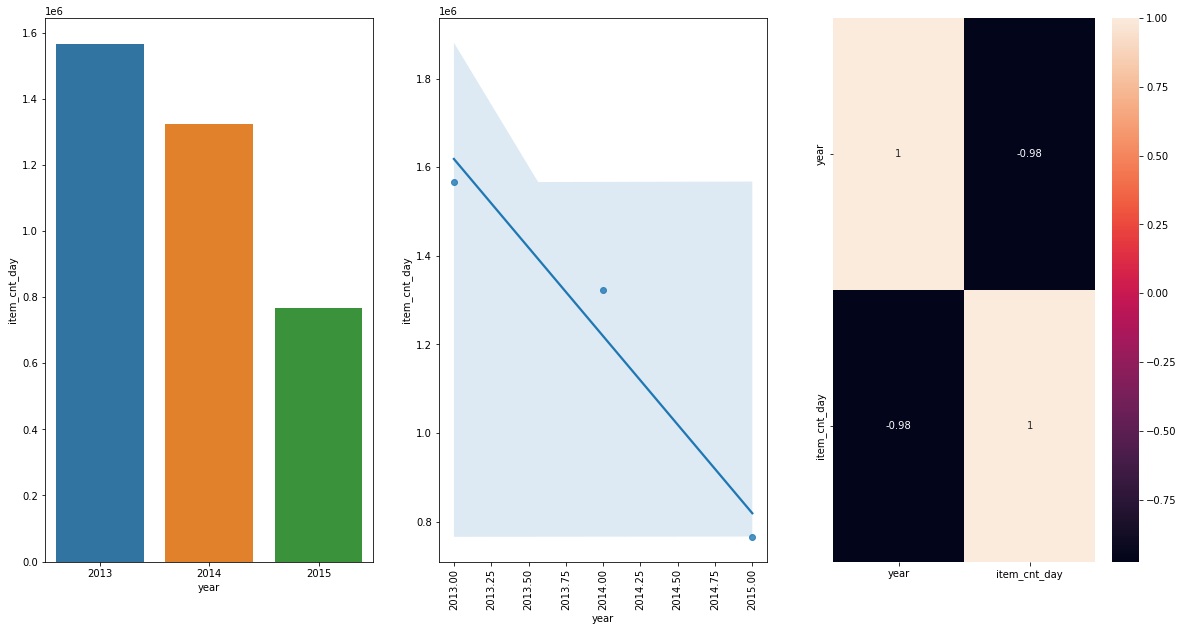

In [27]:
aux1= df4[['year','item_cnt_day']].groupby('year').sum(). reset_index()
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
sns.barplot(x= 'year', y='item_cnt_day', data= aux1);

plt.subplot(1,3,2)
sns.regplot(x= 'year', y='item_cnt_day', data= aux1);
plt.xticks(rotation= 90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method= 'pearson'), annot= True);


### H2 - Lojas no primeiro semestre deveriam vender menos
**FALSA** Lojas vendem igualmente nos dois semestres

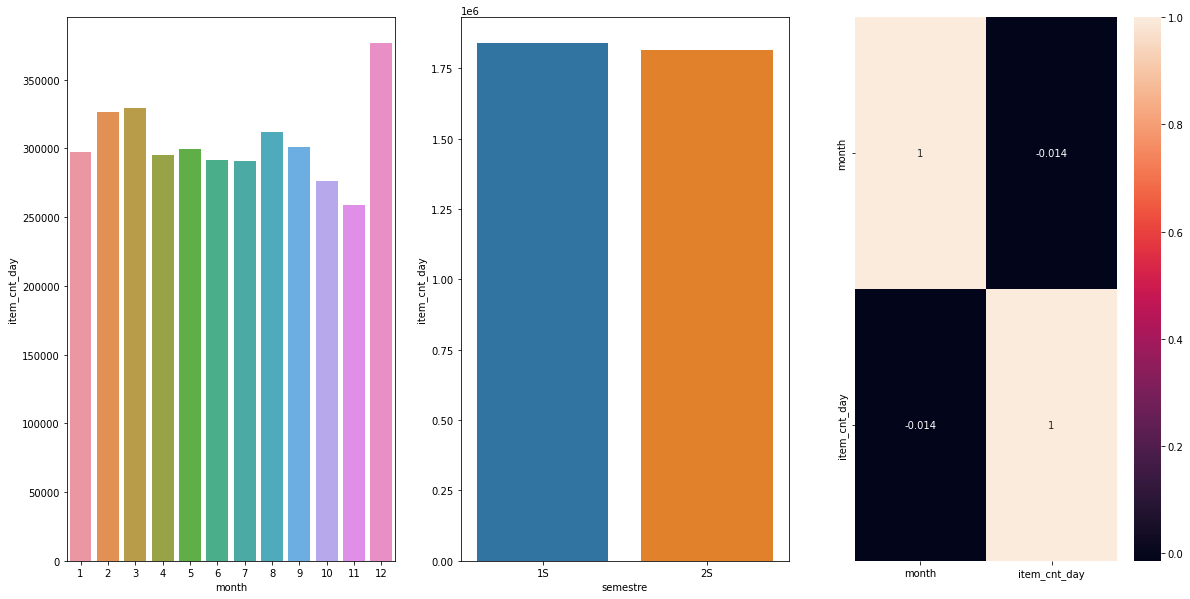

In [28]:
aux1= df4[['month','item_cnt_day']].groupby(['month']).sum().reset_index()

aux1['semestre']= aux1['month'].apply(lambda x: '1S' if x <= 6 else '2S')
aux2= aux1[['semestre','item_cnt_day']].groupby('semestre').sum().reset_index()
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
sns.barplot(x= 'month', y='item_cnt_day', data=aux1);

plt.subplot(1,3,2)
sns.barplot(x= 'semestre', y='item_cnt_day', data= aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method= 'pearson'), annot= True);

### H3 - Lojas até o dia 15 deveriam vender mais
**FALSA** Lojas vendem menos(levemente) nos primeiros 15 dias, tendo um pico no dia 1.

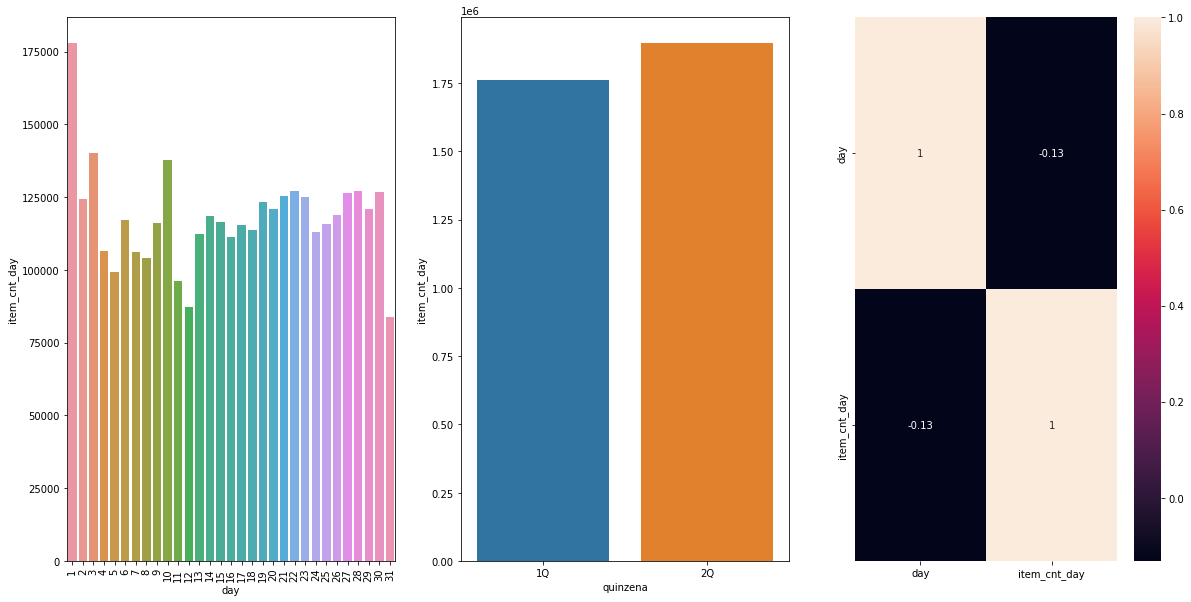

In [29]:
aux1= df4[['day','item_cnt_day']].groupby('day').sum().reset_index()

aux1['quinzena']= aux1['day'].apply(lambda x: '1Q' if x <= 15 else '2Q')
aux2= aux1[['quinzena','item_cnt_day']].groupby('quinzena').sum().reset_index()
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
sns.barplot(x= 'day', y='item_cnt_day', data=aux1);
plt.xticks(rotation= 90)

plt.subplot(1,3,2)
sns.barplot(x= 'quinzena', y='item_cnt_day', data= aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method= 'pearson'), annot= True);

### H4 - Lojas nos meses de temperaturas quentes deveriam vender mais 
**FALSA** Lojas vendem mais nos meses de baixa temperatura

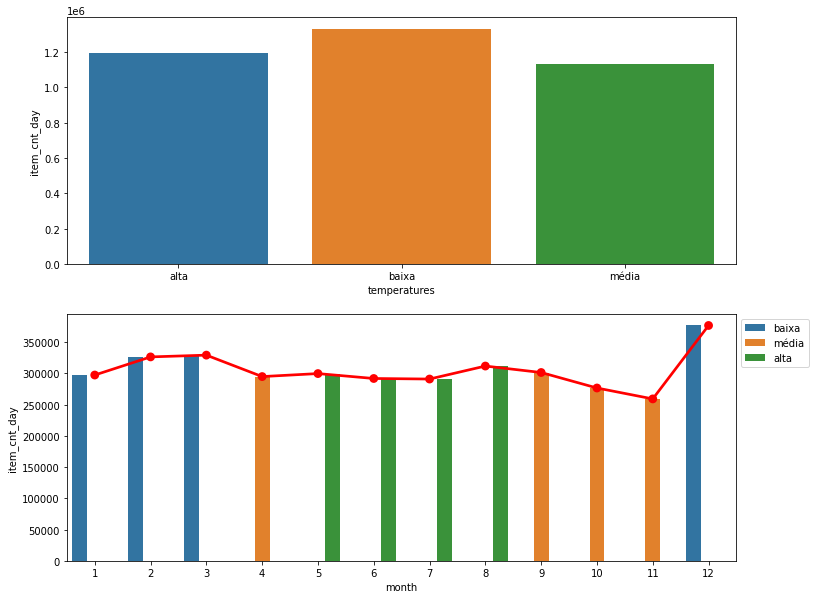

In [30]:
aux1= df4[['temperatures', 'item_cnt_day']].groupby(['temperatures']).sum().reset_index()
aux2= df4[['month', 'temperatures', 'item_cnt_day']].groupby(['month','temperatures']).sum().reset_index()
plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
sns.barplot(x='temperatures', y= 'item_cnt_day', data= aux1);

plt.subplot(2,1,2)
sns.barplot(x='month', y= 'item_cnt_day', hue= 'temperatures', data= aux2);
sns.pointplot(x='month', y= 'item_cnt_day', data= aux2, color= 'red');
plt.legend(loc=2, bbox_to_anchor= (1,1))


### H5 - Lojas no natal deveriam vender mais
**FALSA** Lojas não vendem mais no natal(vendem mais no dia da pátria e do trabalho)

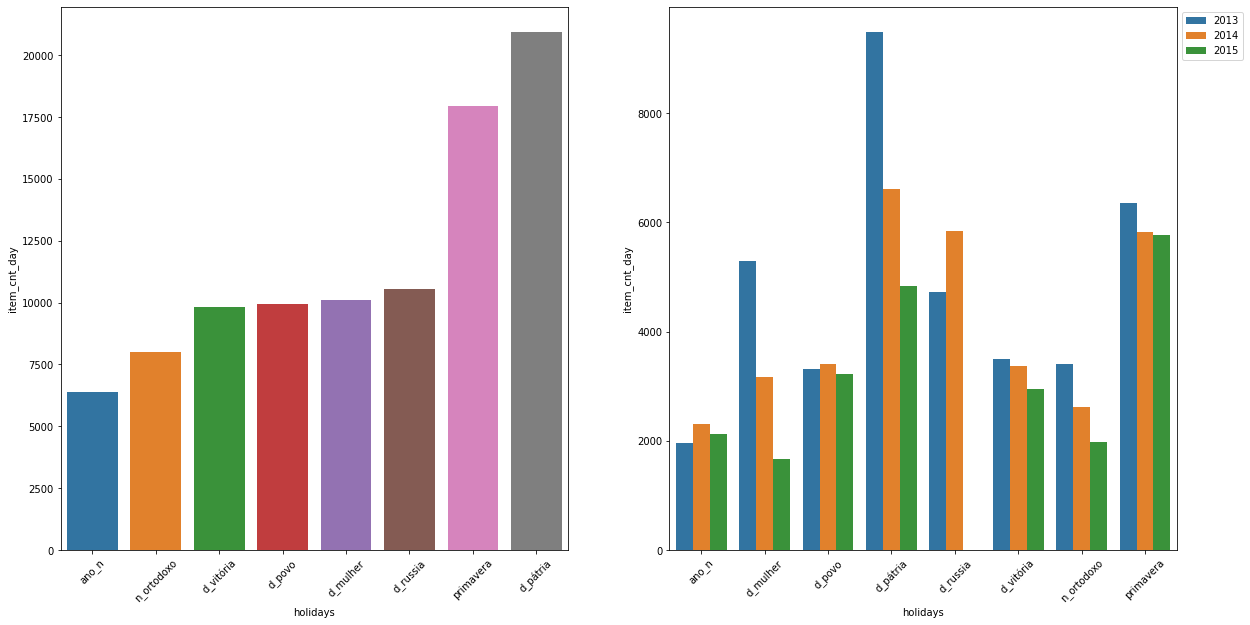

In [31]:
aux= df4.loc[df4['holidays']!= 'nenhum']
aux1= aux[['holidays', 'item_cnt_day']].groupby('holidays').sum().sort_values(by=['item_cnt_day']).reset_index()
aux2= aux[['year', 'holidays', 'item_cnt_day']].groupby(['year','holidays']).sum().reset_index()

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.barplot(x= 'holidays', y= 'item_cnt_day', data= aux1);
plt.xticks(rotation= 45);

plt.subplot(1,2,2)
sns.barplot(x='holidays', y= 'item_cnt_day', hue= 'year', data= aux2);
plt.xticks(rotation= 45);
plt.legend(loc=2, bbox_to_anchor= (1,1));


In [32]:
df4.loc[(df4['month']== 6) &(df4['year']==2015) & (df4['day']==12)]
#não teve vendas pontualmente nos dias 11 e 12 no mês de junho de 2015

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,shop_city,shop_type,item_name,...,day,week_day,week_of_year,year_week,category_general,holidays,temperatures,month_,month_year,price_f


### H6 - Lojas que abrem final de semana deveriam vender mais
**VERDADEIRA** Lojas vendem mais no sábado e no domingo

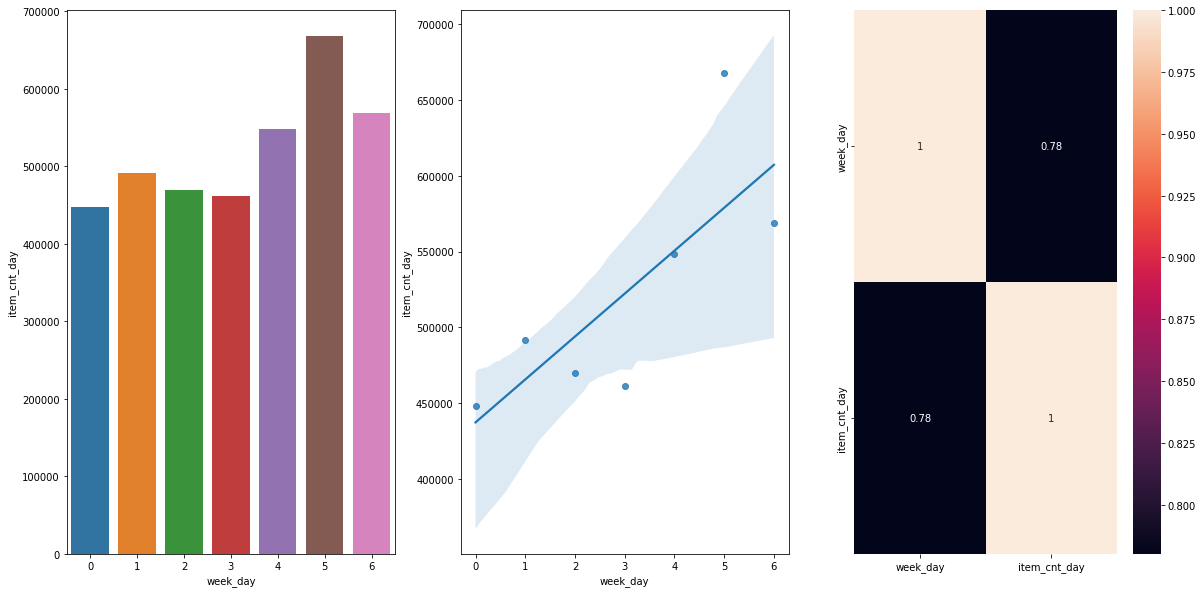

In [33]:
aux1= df4[['week_day', 'item_cnt_day']].groupby(['week_day']).sum().reset_index()
#aux2= df4[['month', 'temperatures', 'item_cnt_day']].groupby(['month','temperatures']).sum().reset_index()
plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
sns.barplot(x='week_day', y= 'item_cnt_day', data= aux1);

plt.subplot(1,3,2)
sns.regplot(x='week_day', y= 'item_cnt_day', data= aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method= 'pearson'), annot= True);

### H7 - Lojas no centro(MOSCOW) deveriam vender mais
**VERDADEIRA** Lojas na cidade de Moscow vendem mais. 

Considerações: as vendas por ano vem diminuindo em Moscow e aumentando nas lojas Online

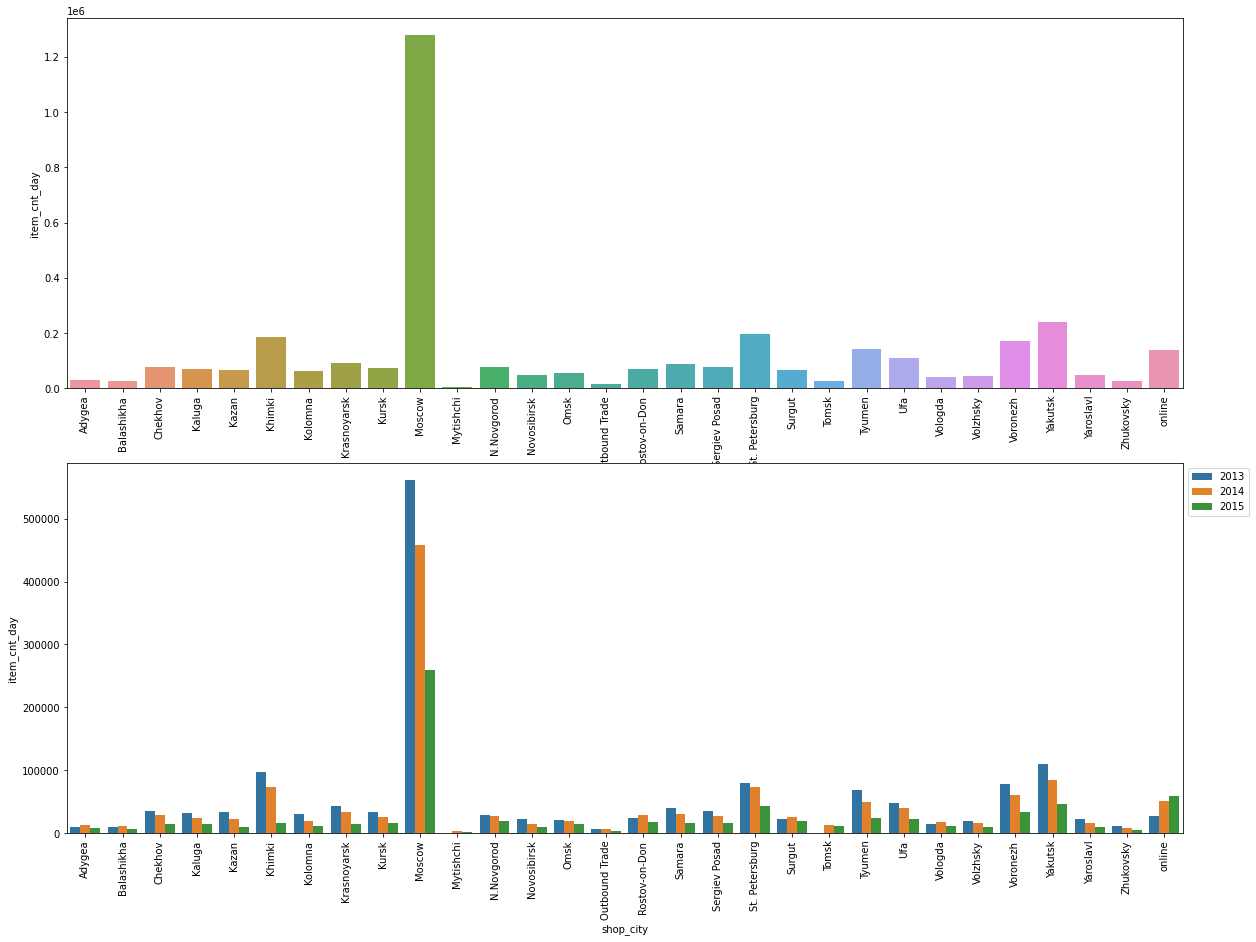

In [34]:
aux1= df4[['shop_city', 'item_cnt_day']].groupby('shop_city').sum().reset_index()

plt.figure(figsize= (20,15))
plt.subplot(2,1,1)
sns.barplot(x= 'shop_city', y= 'item_cnt_day', data= aux1);
plt.xticks(rotation= 90);

plt.subplot(2,1,2)
aux2= df4[['shop_city', 'year', 'item_cnt_day']].groupby(['shop_city','year']).sum().reset_index()
sns.barplot(x='shop_city', y= 'item_cnt_day', hue= 'year', data= aux2);
plt.xticks(rotation= 90);

plt.legend(loc=2, bbox_to_anchor= (1,1));



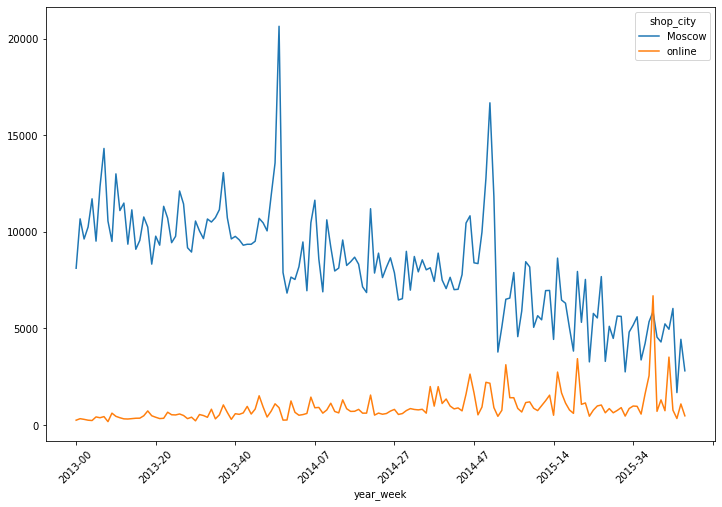

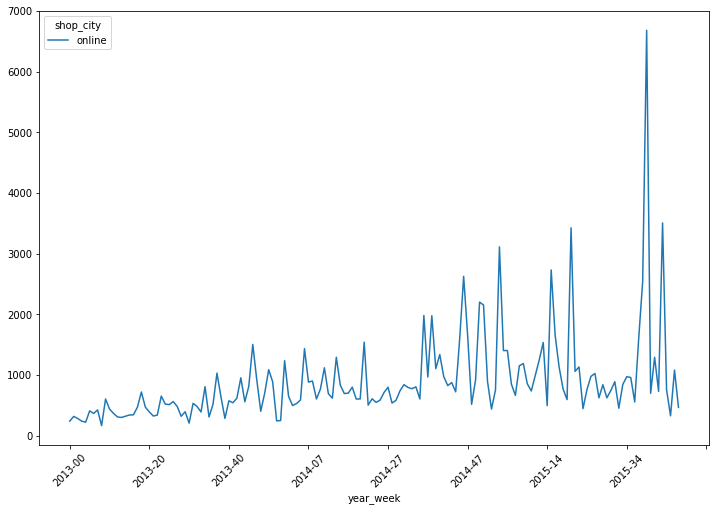

In [35]:
#moscow
aux3= df4[[ 'year_week','shop_city','item_cnt_day']].groupby(['year_week','shop_city']).sum().reset_index()
aux4= aux3.loc[aux3['shop_city'].isin(['online','Moscow'])]

aux4.pivot( index='year_week', columns='shop_city', values='item_cnt_day' ).plot(figsize=(12,8))
plt.xticks(rotation= 45);

#online
aux5= aux4.loc[aux4['shop_city'].isin(['online'])]

aux5.pivot( index='year_week', columns='shop_city', values='item_cnt_day' ).plot(figsize=(12,8))
plt.xticks(rotation= 45);


### H8 - Lojas no shopping deveriam vender mais
**VERDADEIRA** Lojas no shopping vendem mais

Considerações: 

**1.** Lojas são em mais quantidade no shopping center

**2.** As vendas no shopping tem diminuido no decorrer dos anos

**3.** As vendas Online tem aumentando suavemente no decorrer dos anos

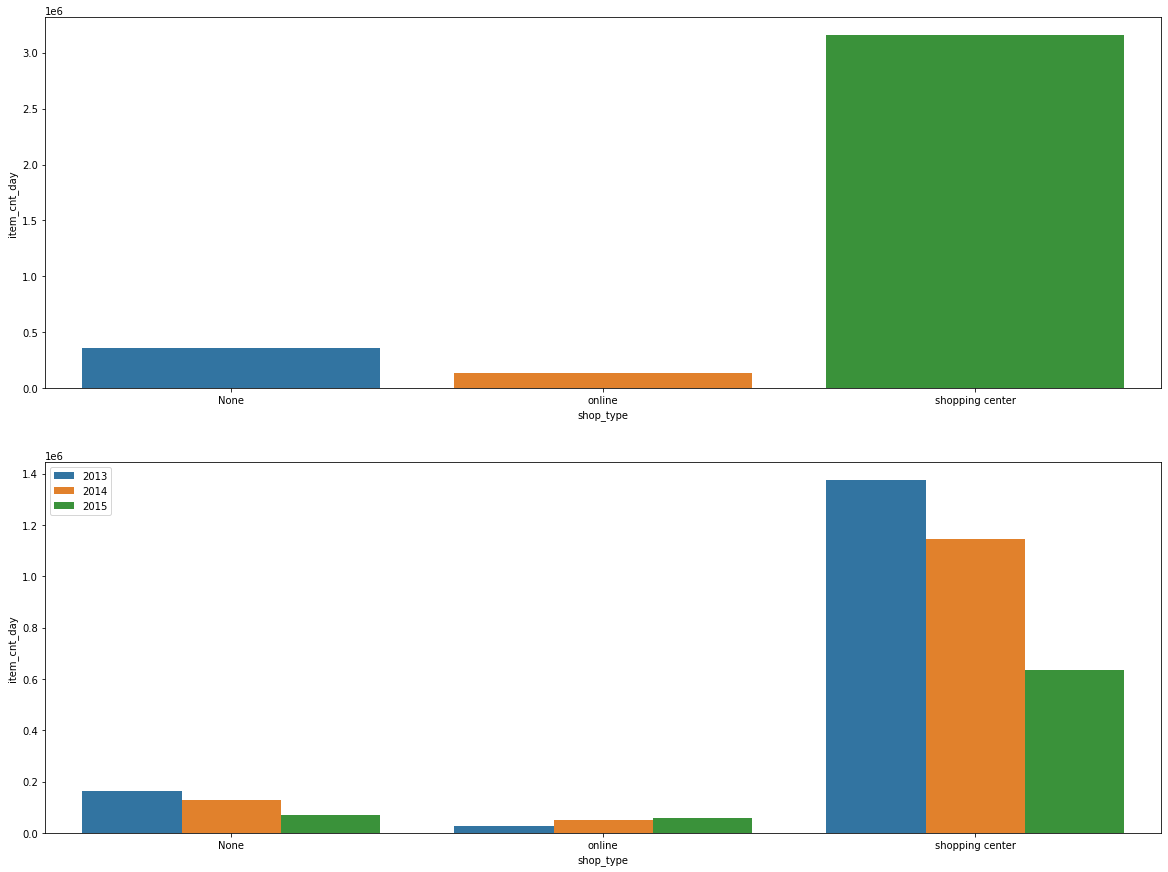

In [36]:
aux1= df4[['shop_type', 'item_cnt_day']].groupby('shop_type').sum().reset_index()

plt.figure(figsize= (20,15))
plt.subplot(2,1,1)
sns.barplot(x= 'shop_type', y= 'item_cnt_day', data= aux1);

plt.subplot(2,1,2)
aux2= df4[['shop_type', 'year', 'item_cnt_day']].groupby(['shop_type','year']).sum().reset_index()
sns.barplot(x='shop_type', y= 'item_cnt_day', hue= 'year', data= aux2);
plt.legend(loc=2);


### H9 - Produtos com faixa de preços menores vendem mais
**FALSA** Produtos na faixa de preço médio vendem mais

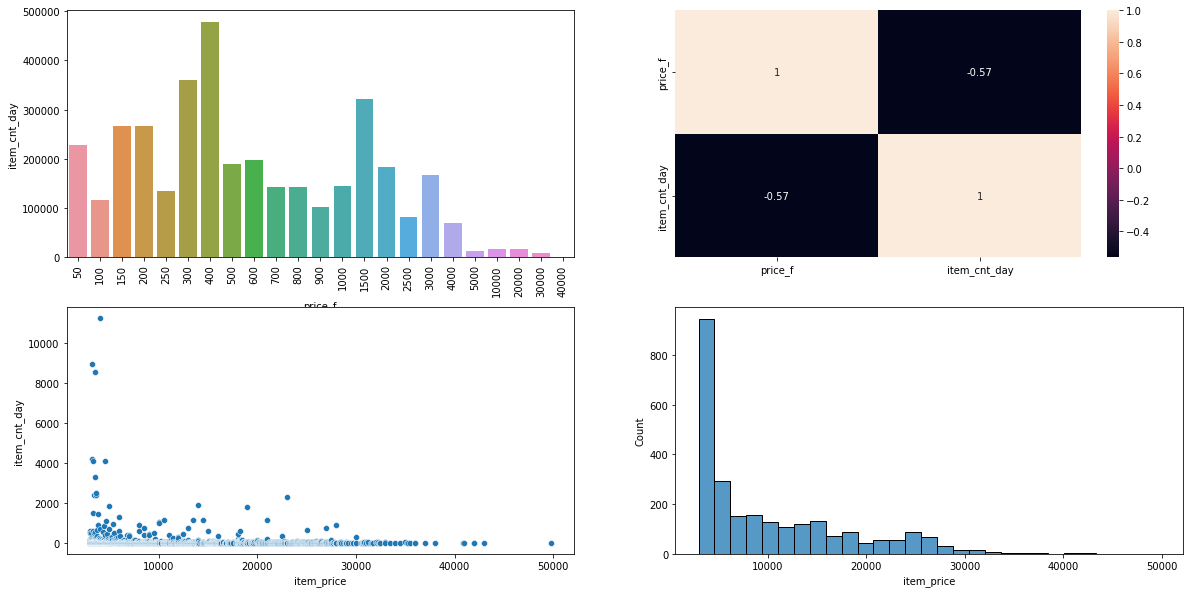

In [37]:
aux1= df4[['price_f','item_cnt_day']].groupby('price_f').sum().reset_index()

#filtros das maiores faixa de preço
aux2= df4.loc[(df4['item_price']>=3000)&(df4['item_price']<=50000)]
aux2= aux3= aux2[['item_price', 'item_cnt_day']].groupby('item_price').sum().reset_index()

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sns.barplot(x='price_f', y='item_cnt_day',data= aux1);
plt.xticks(rotation= 90);

plt.subplot(2,2,2)
sns.heatmap(aux1.corr(method= 'pearson'), annot= True);

plt.subplot(2,2,3)
sns.scatterplot(x='item_price', y='item_cnt_day',data= aux2);

plt.subplot(2,2,4)
sns.histplot(aux2['item_price']);


### 4.2.1 Resumo das hipóteses

In [38]:
tab= [['Hipoteses','Conclusão','Relevância'],
      ['H1','Falsa','Alta'],
      ['H2','Falsa','Baixa'],
      ['H3','Falsa','Baixa'],
      ['H4','Falsa','Baixa'],
      ['H5', 'Falsa','Alta'],
      ['H6','Verdadeira','Alta'],
      ['H7','Verdadeira','Média'],
      ['H8', 'Verdadeira','Média'],
      ['H9','Falsa','Média']]

print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Alta
H2           Falsa        Baixa
H3           Falsa        Baixa
H4           Falsa        Baixa
H5           Falsa        Alta
H6           Verdadeira   Alta
H7           Verdadeira   Média
H8           Verdadeira   Média
H9           Falsa        Média


 ## 4.3 - Análise Multivariada


### 4.3.1 - Variáveis numéricas

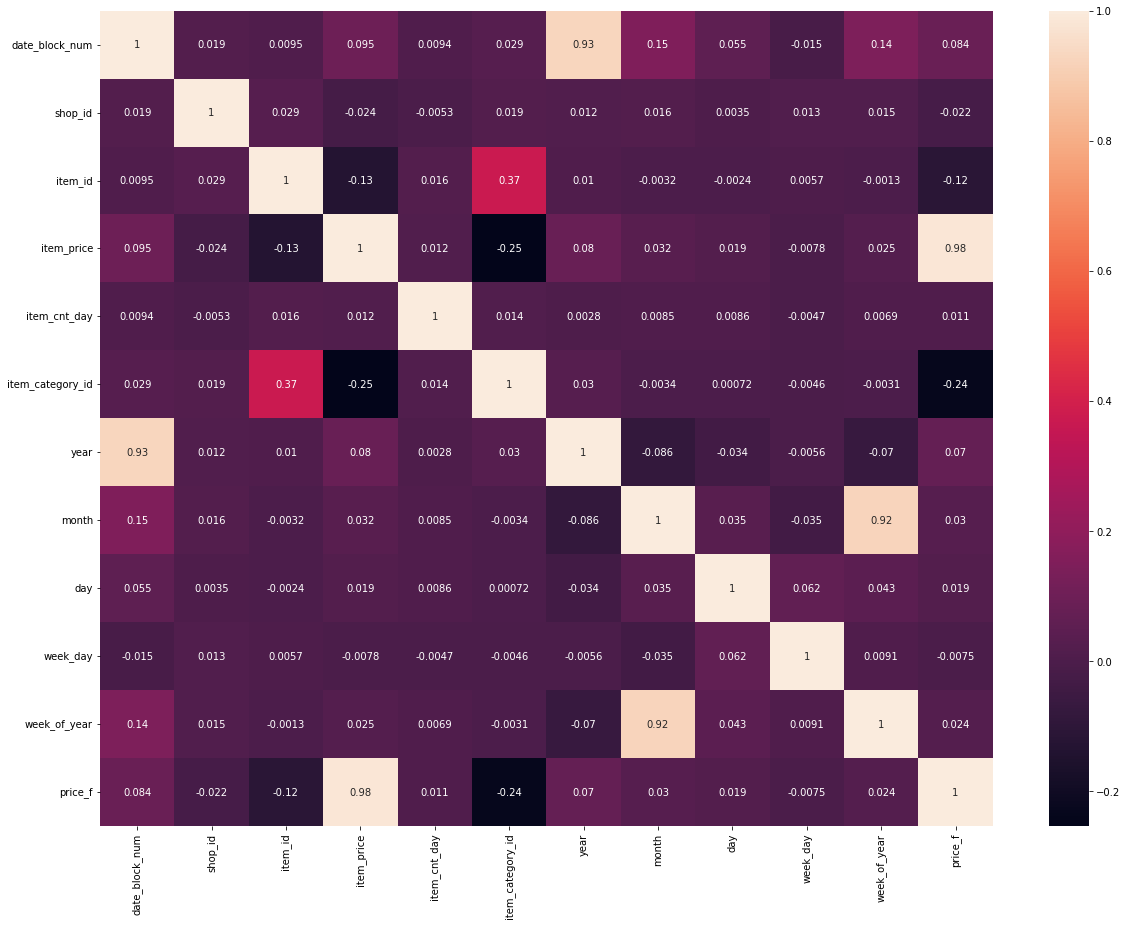

In [39]:
corrl = df4.corr()
f, ax = plt.subplots(figsize=(20,15))
sns.heatmap(corrl, annot= True);

In [40]:
corr_n= df4.corr()['item_cnt_day'].sort_values(ascending= False)
corr_n

item_cnt_day        1.000000
item_id             0.016269
item_category_id    0.014048
item_price          0.011937
price_f             0.010764
date_block_num      0.009435
day                 0.008636
month               0.008502
week_of_year        0.006876
year                0.002781
week_day           -0.004697
shop_id            -0.005325
Name: item_cnt_day, dtype: float64

### 4.3.2 - Variáveis categóricas

In [41]:
a = var_cat[['category_general','holidays','temperatures','shop_city','shop_name']]

a1= cramer_v(a['category_general'],a['category_general'])
a2= cramer_v(a['category_general'],a['holidays'])
a3= cramer_v(a['category_general'],a['temperatures'])
a4= cramer_v(a['category_general'],a['shop_city'])
a5= cramer_v(a['category_general'],a['shop_name'])

a6= cramer_v(a['holidays'],a['category_general'])
a7= cramer_v(a['holidays'],a['holidays'])
a8= cramer_v(a['holidays'],a['temperatures'])
a9= cramer_v(a['holidays'],a['shop_city'])
a10= cramer_v(a['holidays'],a['shop_name'])

a11= cramer_v(a['temperatures'],a['category_general'])
a12= cramer_v(a['temperatures'],a['holidays'])
a13= cramer_v(a['temperatures'],a['temperatures'])
a14= cramer_v(a['temperatures'],a['shop_city'])
a15= cramer_v(a['temperatures'],a['shop_name'])

a16= cramer_v(a['shop_city'],a['category_general'])
a17= cramer_v(a['shop_city'],a['holidays'])
a18= cramer_v(a['shop_city'],a['temperatures'])
a19= cramer_v(a['shop_city'],a['shop_city'])
a20= cramer_v(a['shop_city'],a['shop_name'])

a21= cramer_v(a['shop_name'],a['category_general'])
a22= cramer_v(a['shop_name'],a['holidays'])
a23= cramer_v(a['shop_name'],a['temperatures'])
a24= cramer_v(a['shop_name'],a['shop_city'])
a25= cramer_v(a['shop_name'],a['shop_name'])

#dataset final
d= pd.DataFrame({'category_name':[a1, a2, a3, a4, a5],
                 'holidays':[a6, a7, a8, a9, a10],
                 'temperatures':[a11, a12, a13, a14, a15],
                 'shop_city':[a16, a17, a18, a19, a20],
                 'shop_name':[a21, a22, a23, a24, a25]})

d= d.set_index(d.columns)


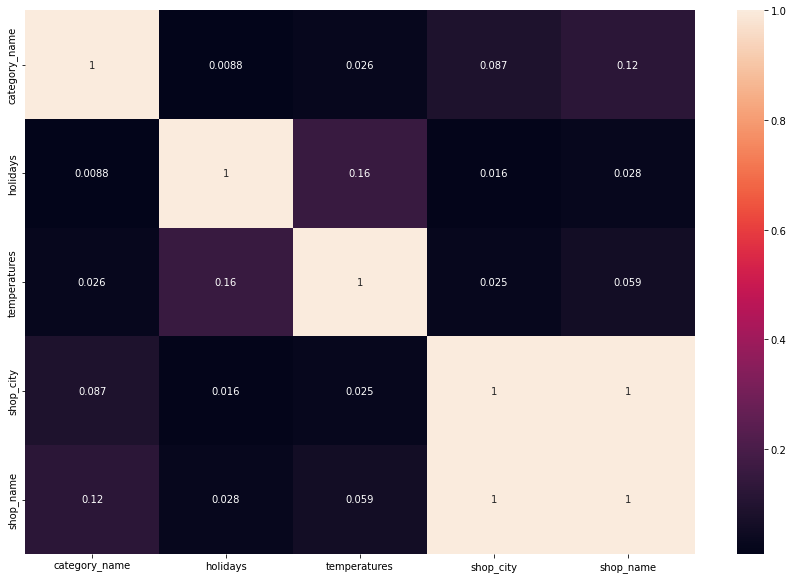

In [42]:
plt.figure(figsize=(15,10))
sns.heatmap(d,annot=True)
plt.show()

# 5 - Moldelagem dos dados

In [36]:
df5= df4.copy()

### 5.1  Transformação

#### 5.1.1 Encoding

In [37]:
#shop_city -   30 cidades (label encoder)
#shop_type -    3 types (Label encoder)
#temperatures - 3 temperatures (Label encoder)
le= LabelEncoder()
for i in ['shop_city', 'shop_type', 'temperatures']:
    df5[i]= le.fit_transform(df5[i])

#holidays - 8 holidays (OHE)
df5 = pd.get_dummies(df5, prefix=['holidays'], columns=['holidays'])


#### 5.1.2 Variável Resposta

In [38]:
#item_cnt_day (log ou box_cox)
df5['item_cnt_day']= np.log1p(df5['item_cnt_day'])

#### 5.1.3 Transformação da natureza

In [39]:
#month 
df5['month_sin']= df5['month'].apply(lambda x: np.sin(x * (2*np.pi/12)))
df5['month_cos']= df5['month'].apply(lambda x: np.cos(x * (2*np.pi/12)))

#day
df5['day_sin']= df5['day'].apply(lambda x: np.sin(x * (2*np.pi/30)))
df5['day_cos']= df5['day'].apply(lambda x: np.cos(x * (2*np.pi/30)))

#week_day
df5['week_day_sin']= df5['week_day'].apply(lambda x: np.sin(x * (2*np.pi/7)))
df5['week_day_cos']= df5['week_day'].apply(lambda x: np.cos(x * (2*np.pi/7)))

#week_of_year
df5['week_of_year_sin']= df5['week_of_year'].apply(lambda x: np.sin(x * (2*np.pi/52)))
df5['week_of_year_cos']= df5['week_of_year'].apply(lambda x: np.cos(x * (2*np.pi/52)))

### 5.2 Rescaling

In [26]:
mms= MinMaxScaler()
rb= RobustScaler()
#year (mms)
#date_block_num(mms)
#shop_id(mms)
#item_id(mms)
#item_category_id(mms)
df5['year']= mms.fit_transform(df5[['year']].values)

#item_price(rs)
df5['item_price']= rb.fit_transform(df5[['item_price']].values)


In [41]:
#deletando colunas auxiliares e originais que deram origem as novas transformadas
cols=["shop_name","item_name", "item_category_name","month_","year_week", "category_general","month_year","price_f","month", "day","week_day","week_of_year"]
df5 = df5.drop(columns= cols)

# 6 - Seleção de Variáveis

In [42]:
df6= df5.copy()

## 6.1 Separação de dados de treino e teste

In [43]:
#separar 6 semanas para dados de teste
df6[['shop_id', 'date']].groupby('shop_id').max().reset_index()['date'][3]- timedelta(days= 6*7)

Timestamp('2015-10-29 00:00:00')

In [44]:
#dataset de treino
X_train = df6[df6['date']<'2015-10-29']
y_train= X_train['item_cnt_day']

#dataset de teste
x_test = df6[df6['date']>= '2015-10-29']
y_test = x_test['item_cnt_day']


In [52]:
print(f'X treino: min={ X_train["date"].min()} e max= { X_train["date"].max()}' )
print(f'\nX teste: min={ x_test["date"].min()} e max= {x_test["date"].max()}' )


X treino: min=2013-01-01 00:00:00 e max= 2015-10-28 00:00:00

X teste: min=2015-10-29 00:00:00 e max= 2015-12-10 00:00:00


## 6.2 Boruta - seleção das variáveis

In [54]:
#treino e teste para boruta(array)
x_train_b= X_train.drop(['date','item_cnt_day'], axis= 1).values
y_train_b= y_train.values.ravel()

In [55]:
#definindo random forest
#rf= RandomForestRegressor(n_jobs=-1)

#definindo Boruta
#boruta= BorutaPy(rf, n_estimators= 'auto', random_state=17, verbose= 2).fit(x_train_b, y_train_b)


### 6.1 Melhores variáveis

In [56]:
#rank das variáveis mais relevantes
#cols_boruta= boruta.support_.tolist()

#melhores variáveis
#x_train_fs= X_train.drop(['date','item_cnt_day'], axis= 1) 

#cols_select_boruta= x_train_fs.iloc[:,cols_boruta].columns.to_list()

#variáveis não selecionadas pelo boruta
#cols_not_boruta= list(np.setdiff1d(x_train_fs.columns,cols_select_boruta))


In [57]:
#cols_select_boruta

In [58]:
#cols_not_boruta

## 6.2 Seleção das variáveis manual

In [32]:
cols_select_boruta= ['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_category_id']

#adicionando colunas
f_add= ['date', 'item_cnt_day']

cols_select_boruta_full= cols_select_boruta.copy()
cols_select_boruta_full.extend(f_add)

# 7 - Machine Learning

In [ ]:
#dados de treino e teste para modelos de ML
x_train = X_train[cols_select_boruta]
x_test_ml = x_test[cols_select_boruta]

#dados para Times Series
x_training = X_train[cols_select_boruta_full]

## 7.1 Moldelo de Média simples

In [61]:
aux1= x_test_ml.copy()
aux1['item_cnt_day']= y_test.copy()

#previsões por média
aux2= aux1[['shop_id', 'item_cnt_day']].groupby('shop_id').mean().reset_index().rename(columns= {'item_cnt_day': 'predictions'})

aux1= pd.merge(aux1,aux2, how='left', on= 'shop_id')
yhat_baseline= aux1['predictions']

#performance
baseline_result= ml_error('Média simples', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Média simples,0.27907,0.142601,1.680047


## 7.2 Moldelo Linear Regression

In [62]:
#model
lr= LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr= lr.predict(x_test_ml)

#performance
lr_result= ml_error('Linear Regression',np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,0.31104,0.174638,1.686022


### 7.2.1 Linear Regression - Cross Validation

In [66]:
lr_result_cv = cross_validation(x_training, 'Linear Regression CV', lr, 5, verbose= True)
lr_result_cv


Kfold Number: 5

Kfold Number: 4

Kfold Number: 3

Kfold Number: 2

Kfold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression CV,0.4+/-0.09,0.18+/-0.01,4.01+/-3.24


### 7.3 Moldelo Lasso

In [67]:
#model
lrr= Lasso(alpha= 0.01).fit(x_train, y_train)

#prediction
yhat_lrr= lrr.predict(x_test_ml)

#performance
lrr_result= ml_error('Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,0.308321,0.171751,1.685881


### 7.3.1 Modelo Lasso - Cross Validation

In [70]:
lrr_result_cv = cross_validation(x_training, 'Lasso CV', lrr, 5, verbose= True)
lrr_result_cv


Kfold Number: 5

Kfold Number: 4

Kfold Number: 3

Kfold Number: 2

Kfold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso CV,0.4+/-0.09,0.18+/-0.01,4.01+/-3.24


## 7.4 Moldelo Random Forest Regressor

In [71]:
#model
rf= RandomForestRegressor(n_estimators= 100, n_jobs= -1, random_state= 17).fit(x_train, y_train)

#prediction
yhat_rf= rf.predict(x_test_ml)

#performance
rf_result= ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,0.20625,0.107743,1.397099


### 7.4.1 Random Forest - Cross Validation

In [72]:
rf_result_cv = cross_validation(x_training, 'Random Forest CV', rf, 5, verbose= True)
rf_result_cv


Kfold Number: 5

Kfold Number: 4

Kfold Number: 3

Kfold Number: 2

Kfold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest CV,0.31+/-0.09,0.12+/-0.01,3.88+/-3.27


## 7.5 Moldelo XGBoost

In [73]:
#model
model_xgb= xgb.XGBRegressor(n_estmators= 100,objective= 'reg:squarederror',
                           eta= 0.01, max_depth= 10, subsample= 0.7,
                           cosample_bytee= 0.9).fit(x_train, y_train)

#predict
yhat_xgb= model_xgb.predict(x_test_ml)

#performance
xgb_result= ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

[10:49:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "cosample_bytee", "n_estmators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,0.267469,0.136728,1.625393


### 7.5.1 XGBoost- Cross Validation

In [74]:
xgb_result_cv = cross_validation(x_training, 'XGBoost CV',model_xgb, 5, verbose= True)
xgb_result_cv


Kfold Number: 5
[10:52:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "cosample_bytee", "n_estmators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



Kfold Number: 4
[10:55:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "cosample_bytee", "n_estmators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



Kfold Number: 3
[10:57:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_releas

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost CV,0.35+/-0.09,0.14+/-0.0,3.96+/-3.27


## 7.6 Comparação dos modelos

In [75]:
model_result= pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
model_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,0.206250,0.107743,1.397099
0,XGBoost Regressor,0.267469,0.136728,1.625393
0,Média simples,0.279070,0.142601,1.680047
0,Lasso,0.308321,0.171751,1.685881
0,Linear Regression,0.311040,0.174638,1.686022


## 7.6.1 Comparação dos modelos - Cross Validation

In [77]:
model_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
model_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest CV,0.31+/-0.09,0.12+/-0.01,3.88+/-3.27
0,XGBoost CV,0.35+/-0.09,0.14+/-0.0,3.96+/-3.27
0,Linear Regression CV,0.4+/-0.09,0.18+/-0.01,4.01+/-3.24
0,Lasso CV,0.4+/-0.09,0.18+/-0.01,4.01+/-3.24


In [78]:
#Salvando variáveis para usar depois 
with open('russia_v.pkl', mode= 'wb') as f:
    pickle.dump([x_train, y_train, x_test_ml, y_test],f)

In [80]:
#salvando o modelo 
pickle.dump(rf, open('rf_vendas.pkl', mode= 'wb'))

# 8 - Hyperpameter Fine Tuning

Nesse primeiro ciclo do CRISP não será realizado o fine tuning, pois o modelo já está com valores baixos de erros.

# 9 - Tradução e Interpretação do erro

In [28]:
#variáveis 
with open('russia_v.pkl', mode= 'rb') as f:
    x_train, y_train, x_test_ml, y_test = pickle.load(f)

In [29]:
#modelo treinado
with open('rf_vendas.pkl', mode= 'rb') as rf:
    rf= pickle.load(rf)

In [30]:
#previsões nos dados de teste
yhat_rf= rf.predict(x_test_ml)


In [45]:
df9= x_test[cols_select_boruta_full]
#rescala
df9['item_cnt_day']= np.expm1(df9['item_cnt_day'])
df9['predictions']= np.round(np.expm1(yhat_rf))

## 9.1 Performance de Negócio 

In [46]:
#soma das predições por loja
df91= df9[['shop_id', 'predictions']].groupby('shop_id').sum().reset_index()

#MAE e MAPE
df9_aux1= df9[['shop_id', 'item_cnt_day', 'predictions']].groupby('shop_id').apply(
    lambda x: mean_absolute_error(x['item_cnt_day'],x['predictions'])).reset_index().rename(columns={0:'MAE'})

df9_aux2= df9[['shop_id', 'item_cnt_day', 'predictions']].groupby('shop_id').apply(
lambda x: mean_absolute_percentage_error(x['item_cnt_day'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

#merge
df9_aux3= pd.merge(df9_aux1, df9_aux2, how='inner', on= 'shop_id')
df92= pd.merge(df91, df9_aux3, how= 'inner', on= 'shop_id')

#cenários
df92['worst_scenario']= df92['predictions']- df92['MAE']
df92['best_scenario']= df92['predictions'] + df92['MAE']

#ordenando colunas
df92= df92[['shop_id', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [47]:
df92.sort_values('MAPE', ascending= False).head()

,shop_id,predictions,worst_scenario,best_scenario,MAE,MAPE
47,55,1611.0,1609.766502,1612.233498,1.233498,0.245955
8,12,995.0,994.564356,995.435644,0.435644,0.150294
9,14,711.0,710.794830,711.205170,0.205170,0.122294
34,42,2776.0,2775.714161,2776.285839,0.285839,0.119377
46,54,580.0,579.781186,580.218814,0.218814,0.116696


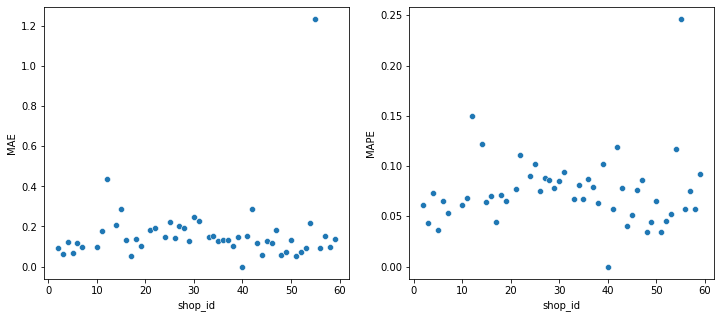

In [58]:
plt.figure(figsize= (12,5))

plt.subplot(1,2,1)
sns.scatterplot(x= 'shop_id', y='MAE', data= df92);

plt.subplot(1,2,2)
sns.scatterplot(x= 'shop_id', y= 'MAPE', data= df92);


## 9.2 Performance Total

In [65]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis= 0).reset_index().rename(columns={'index':'Scenario', 0:'Values'})
df93['Values']= df93['Values'].map('{:.2f}'.format)
df93

,Scenario,Values
0,predictions,50062.00
1,worst_scenario,50053.53
2,best_scenario,50070.47


## 9.3 Machine Learning Performance

In [66]:
df9['error']= df9['item_cnt_day']- df9['predictions']
df9['error_rate']= df9['predictions']/df9['item_cnt_day']

<AxesSubplot:xlabel='predictions', ylabel='error'>

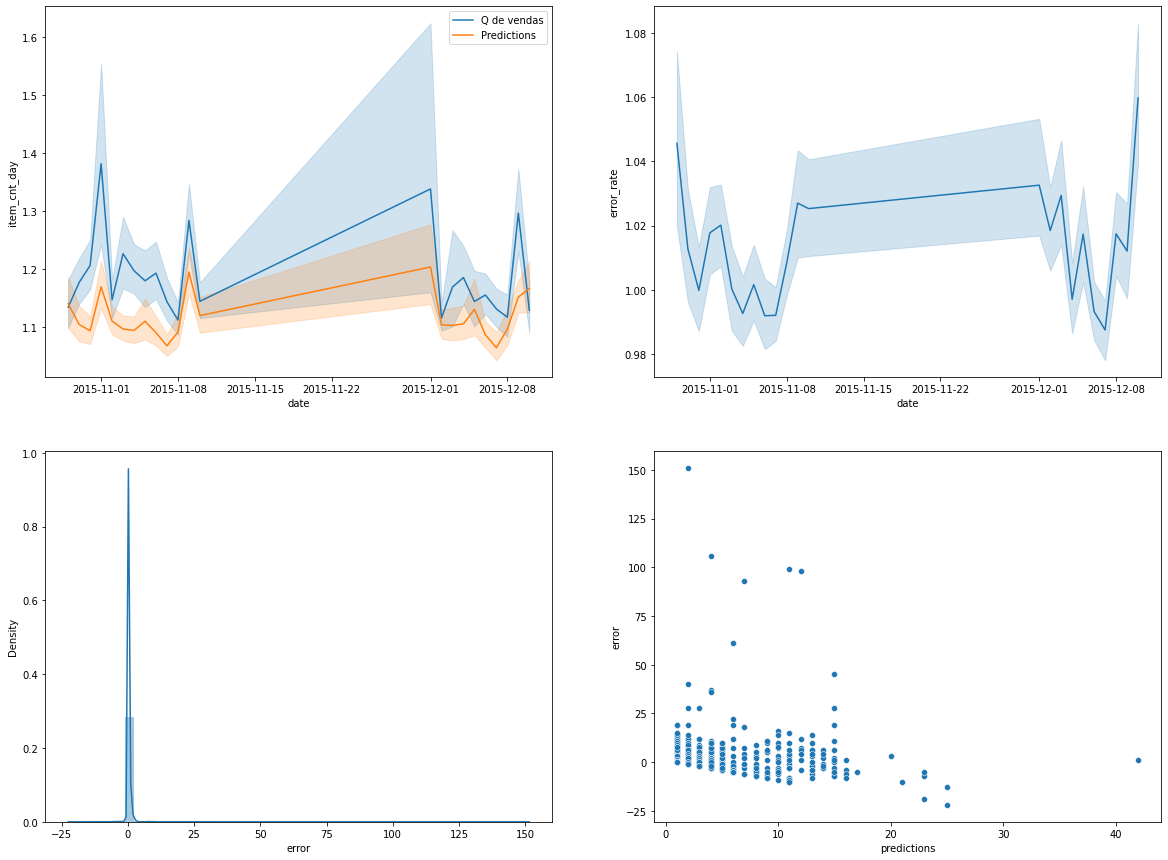

In [68]:
plt.figure(figsize=(20,15))

plt.subplot(2,2,1)
sns.lineplot(x= 'date', y='item_cnt_day', data= df9, label= 'Q de vendas')
sns.lineplot(x= 'date', y='predictions', data= df9, label= 'Predictions')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data= df9)

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error'])


# 10 - 2º Etapa do Ciclo CRISP- DS

Vamos considerar nessa segunda etapa o agrupamento das vendas por loja e data, para podermos analisar se o modelo generaliza mais, ao inves de ser por item e loja que tem muitos valores próximos de 1.

In [34]:
#Função Cross Validation - 2ª Etapa do Ciclo CRISP-DS

def cross_2c_validation(x_training, model_name, model, kfold, verbose= False):
    mae_list= []
    mape_list= []
    rmse_list= []
    
    for k in reversed( range(1, kfold+1) ):
        if verbose:
            print(f'\nKfold Number: {k}')
        #data de inicio e fim dos dados de validação
        validation_start = x_training['date'].max()- timedelta(days= k*6*7)
        validation_end = x_training['date'].max() - timedelta(days= (k-1)*6*7)

        #filtrando dataset por datas
        train = x_training[x_training['date']< validation_start]
        validation = x_training[(x_training['date']>= validation_start) & (x_training['date']<= validation_end)]

        #dados de treino e validação 
        #treino
        xtraining= train.drop(['date', 'sales'], axis = 1)
        ytraining= train['sales']

        #validação
        xvalidation= validation.drop(['date', 'sales'], axis= 1)
        yvalidation= validation['sales']

        #modelo
        m= model.fit(xtraining, ytraining)

        #previsão
        yhat= m.predict(xvalidation)

        #performance
        ml_result= ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        #média das performances por iterações (kfolds)
        mae_list.append(ml_result['MAE'])
        mape_list.append(ml_result['MAPE'])
        rmse_list.append(ml_result['RMSE'])
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list),2).astype(str)+ '+/-' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list),2).astype(str)+ '+/-' +np.round(np.std(mape_list),2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str)+ '+/-' +np.round(np.std(rmse_list),2).astype(str)}, index=[0])


In [22]:
#Criando variável resposta 'sales', vendas diárias de cada loja.
df_sales= df4[['date','shop_name', 'item_cnt_day']].groupby(['shop_name','date']).sum().reset_index()
df_sales['dict']= df_sales['shop_name']+ df_sales['date'].astype(str)

df4['dict']= df4['shop_name']+ df4['date'].astype(str)
sales_dict = dict(zip(df_sales['dict'], df_sales['item_cnt_day']))
df4['sales']= df4['dict'].map(sales_dict)
df4.drop('dict', axis=1, inplace = True)


In [23]:
#criando variável price_sales que corresponde ao item_price por data 
df_price = df4[['date', 'shop_name', 'item_price']].groupby(['shop_name', 'date']).sum().reset_index()
df_price['dict']= df_price['shop_name']+ df_price['date'].astype(str)

df4['dict_p']= df4['shop_name']+df4['date'].astype(str)
price_dict= dict(zip(df_price['dict'], df_price['item_price']))
df4['price_sales']= df4['dict_p'].map(price_dict)
df4.drop('dict_p', axis= 1, inplace= True)

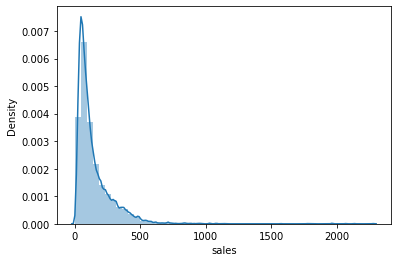

In [24]:
#verificando a distribuição de novas variáveis
sns.distplot(df4['sales']);


## 10.1 Transformações nas variáveis

In [27]:
#Selecionando apenas as varíáveis que vamos utilizar
df4s= df4[['date_block_num', 'shop_id', 'price_sales', 'item_category_id', 'date','sales']]

#transformações necessárias
df4s['price_sales']= rb.fit_transform(df4s[['price_sales']].values)
df4s['sales']= np.log1p(df4s['sales'])

#dados de treino 
XS_train= df4s[df4s['date']<'2015-10-29']
ys_train= XS_train['sales']

#dados de teste
xs_test= df4s[df4s['date']>= '2015-10-29']
ys_test= xs_test['sales']

#dados de treino e teste para modelos de ML
xs_train= XS_train.drop(['date','sales'], axis=1)
xs_test_ml = xs_test.drop(['date','sales'], axis= 1)


## 10.2 Treinando modelos 

### 10.2.1 Média simples

In [28]:
aux1s= xs_test_ml.copy()
aux1s['sales']= ys_test.copy()

#previsões por média
aux2s= aux1s[['shop_id', 'sales']].groupby('shop_id').mean().reset_index().rename(columns= {'sales': 'predictions'})

aux1s= pd.merge(aux1s,aux2s, how='left', on= 'shop_id')
yhats_baseline= aux1s['predictions']

#performance
baselines_result= ml_error('Média simples - Sales', np.expm1(ys_test), np.expm1(yhats_baseline))
baselines_result

,Model Name,MAE,MAPE,RMSE
0,Média simples - Sales,26.49173,0.347221,41.6898


### 10.2.2 Modelos Lineares

In [29]:
#model
lrs= LinearRegression().fit(xs_train, ys_train)

#prediction
yhats_lr= lrs.predict(xs_test_ml)

#performance
lrs_result= ml_error('Linear Regression - Sales',np.expm1(ys_test), np.expm1(yhats_lr))
lrs_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Sales,32.051099,0.386571,51.802242


In [30]:
#model
lasso_s= Lasso().fit(xs_train, ys_train)

#prediction
yhats_lasso= lasso_s.predict(xs_test_ml)

#performance
lasso_s_result= ml_error('Lasso - Sales',np.expm1(ys_test), np.expm1(yhats_lasso))
lasso_s_result

,Model Name,MAE,MAPE,RMSE
0,Lasso - Sales,61.765767,1.163751,78.426241


### 10.2.2.1 Modelos lineares - CV

In [35]:
lrs_result_cv = cross_2c_validation(XS_train, 'Linear Regression CV', lrs, 5, verbose= True)
lrs_result_cv



Kfold Number: 5

Kfold Number: 4

Kfold Number: 3

Kfold Number: 2

Kfold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression CV,36.72+/-5.42,0.38+/-0.02,72.91+/-25.5


In [36]:
lasso_s_result_cv = cross_2c_validation(XS_train, 'Lasso CV', lasso_s, 5, verbose= True)
lasso_s_result_cv


Kfold Number: 5

Kfold Number: 4

Kfold Number: 3

Kfold Number: 2

Kfold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso CV,69.1+/-8.15,1.3+/-0.05,99.82+/-22.44


### 10.2.3 Modelo Random Forest

In [32]:
#model
rfs= RandomForestRegressor(n_estimators= 100, n_jobs= -1, random_state= 17).fit(xs_train, ys_train)

#prediction
yhats_rf= rfs.predict(xs_test_ml)

#performance
rfs_result= ml_error('Random Forest Regressor- Sales', np.expm1(ys_test), np.expm1(yhats_rf))
rfs_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor- Sales,21.022149,0.246425,36.076778


### 10.2.3.1 Random Forest - CV

In [37]:
rfs_result_cv = cross_2c_validation(XS_train, 'Random Forest CV', rfs, 5, verbose= True)
rfs_result_cv


Kfold Number: 5

Kfold Number: 4

Kfold Number: 3

Kfold Number: 2

Kfold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest CV,25.73+/-4.06,0.27+/-0.02,60.15+/-27.84


### 10.2.4 Modelo XGBoost

In [33]:
#model
model_xgb_s= xgb.XGBRegressor(n_estmators= 100,objective= 'reg:squarederror',
                           eta= 0.01, max_depth= 10, subsample= 0.7,
                           cosample_bytee= 0.9).fit(xs_train, ys_train)

#predict
yhats_xgb= model_xgb_s.predict(xs_test_ml)

#performance
xgbs_result= ml_error('XGBoost Regressor - Sales', np.expm1(ys_test), np.expm1(yhats_xgb))
xgbs_result

[14:48:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "cosample_bytee", "n_estmators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor - Sales,75.118704,0.738876,102.494434


### 10.2.4.1 Moldelo XGBoost- CV

In [41]:
xgbs_result_cv = cross_2c_validation(XS_train, 'XGBoost CV',model_xgb_s, 5, verbose= True)
xgbs_result_cv


Kfold Number: 5
[15:20:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "cosample_bytee", "n_estmators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



Kfold Number: 4
[15:22:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "cosample_bytee", "n_estmators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



Kfold Number: 3
[15:25:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_releas

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost CV,80.57+/-10.13,0.74+/-0.01,122.1+/-22.55


### 10.2.5 Comparação dos modelos 

In [39]:
models_result= pd.concat([baselines_result, lrs_result, lasso_s_result, rfs_result, xgbs_result])
models_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor- Sales,21.022149,0.246425,36.076778
0,Média simples - Sales,26.491730,0.347221,41.689800
0,Linear Regression - Sales,32.051099,0.386571,51.802242
0,Lasso - Sales,61.765767,1.163751,78.426241
0,XGBoost Regressor - Sales,75.118704,0.738876,102.494434


### 10.2.5.1 Comparação dos modelos - CV

In [50]:
models_cv_result= pd.concat([lrs_result_cv, lasso_s_result_cv, rfs_result_cv, xgbs_result_cv])
models_cv_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression CV,36.72+/-5.42,0.38+/-0.02,72.91+/-25.5
0,Lasso CV,69.1+/-8.15,1.3+/-0.05,99.82+/-22.44
0,Random Forest CV,25.73+/-4.06,0.27+/-0.02,60.15+/-27.84
0,XGBoost CV,80.57+/-10.13,0.74+/-0.01,122.1+/-22.55


# 11 - Interpretação do erro - 2º Etapa do Ciclo CRISP-DS

In [53]:
#previsões nos dados de teste
yhats_rf= rfs.predict(xs_test_ml)

df10= xs_test
#rescala
df10['sales']= np.expm1(df10['sales'])
df10['predictions']= np.round(np.expm1(yhats_rf))

## 11.1 Performance de Negócio 

In [54]:
#soma das predições por loja
df101= df10[['shop_id', 'predictions']].groupby('shop_id').sum().reset_index()

#MAE e MAPE
df10_aux1= df10[['shop_id', 'sales', 'predictions']].groupby('shop_id').apply(
    lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAE'})

df10_aux2= df10[['shop_id', 'sales', 'predictions']].groupby('shop_id').apply(
lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

#merge
df10_aux3= pd.merge(df10_aux1, df10_aux2, how='inner', on= 'shop_id')
df102= pd.merge(df101, df10_aux3, how= 'inner', on= 'shop_id')

#cenários
df102['worst_scenario']= df102['predictions']- df102['MAE']
df102['best_scenario']= df102['predictions'] + df102['MAE']

#ordenando colunas
df102= df102[['shop_id', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [55]:
df102.sort_values('MAPE', ascending= False).head()

,shop_id,predictions,worst_scenario,best_scenario,MAE,MAPE
35,43,3300.0,3280.100000,3319.900000,19.900000,0.650256
7,11,271.0,265.235294,276.764706,5.764706,0.540701
0,2,14156.0,14145.705305,14166.294695,10.294695,0.411388
51,59,23525.0,23510.486280,23539.513720,14.513720,0.403411
8,12,66478.0,66451.050919,66504.949081,26.949081,0.382725


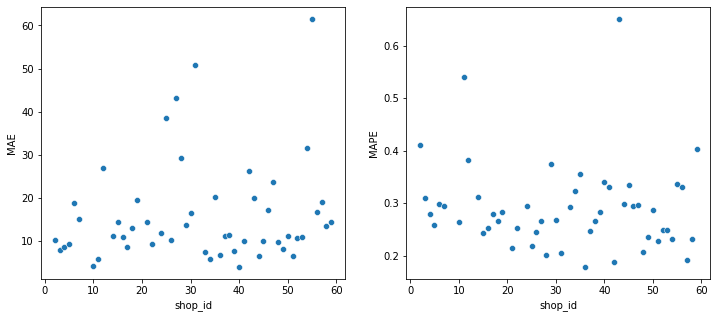

In [56]:
plt.figure(figsize= (12,5))

plt.subplot(1,2,1)
sns.scatterplot(x= 'shop_id', y='MAE', data= df102);

plt.subplot(1,2,2)
sns.scatterplot(x= 'shop_id', y= 'MAPE', data= df102);

## 11.2 Performance Total

In [57]:
df103 = df102[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis= 0).reset_index().rename(columns={'index':'Scenario', 0:'Values'})
df103['Values']= df103['Values'].map('{:.2f}'.format)
df103

,Scenario,Values
0,predictions,3921424.00
1,worst_scenario,3920597.55
2,best_scenario,3922250.45


## 11.3 Machine learning performance

In [58]:
df10['error']= df10['sales']- df10['predictions']
df10['error_rate']= df10['predictions']/df10['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

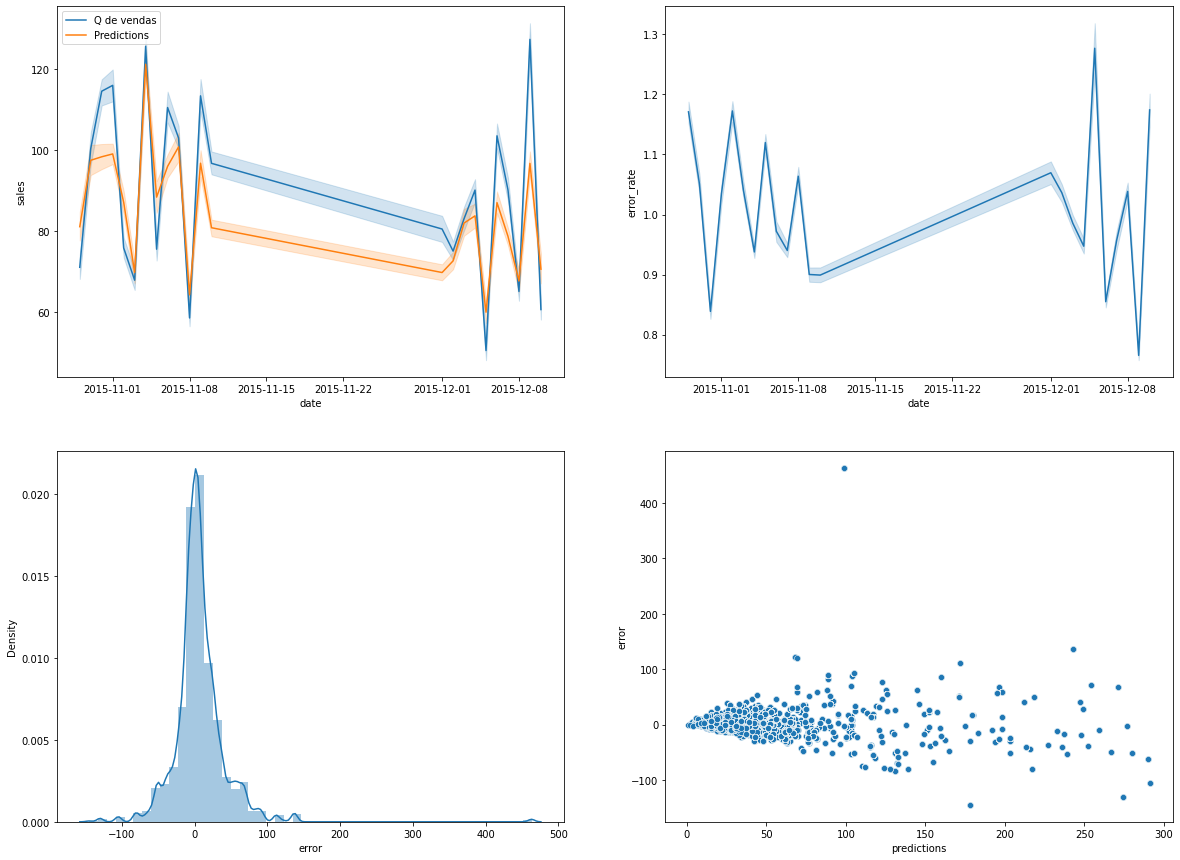

In [59]:
plt.figure(figsize=(20,15))

plt.subplot(2,2,1)
sns.lineplot(x= 'date', y='sales', data= df10, label= 'Q de vendas')
sns.lineplot(x= 'date', y='predictions', data= df10, label= 'Predictions')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data= df10)

plt.subplot(2,2,3)
sns.distplot(df10['error'])

plt.subplot(2,2,4)
sns.scatterplot(df10['predictions'], df10['error'])